## Pumpkin Pricing

Load up required libraries and dataset. Convert the data to a dataframe containing a subset of the data: 

- Only get pumpkins priced by the bushel
- Convert the date to a month
- Calculate the price to be an average of high and low prices
- Convert the price to reflect the pricing by bushel quantity

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns



#this is to test fetching

In [3]:
pumpkins = pd.read_csv('../data/US-pumpkins.csv')

pumpkins.head()

,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [4]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

price = round((pumpkins['Low Price'] + pumpkins['High Price'] / 2),1)

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = round(price/1.1,1)
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = round(price*2,1)

new_pumpkins.head()


,Month,DayOfYear,Variety,City,Package,Low Price,High Price,Price
70,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,20.5
71,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,24.5
72,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,24.5
73,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,23.2
74,10,281,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,20.5


A basic scatterplot reminds us that we only have month data from August through December. We probably need more data to be able to draw conclusions in a linear fashion.

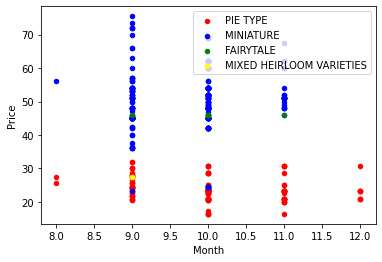

In [5]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
     df = new_pumpkins[new_pumpkins['Variety']==var]
     ax = df.plot.scatter('Month','Price',ax=ax,c=colors[i],label=var)

In [6]:
type_pumpkin=new_pumpkins.loc[new_pumpkins['Variety']=="PIE TYPE"]

<AxesSubplot:xlabel='Month'>

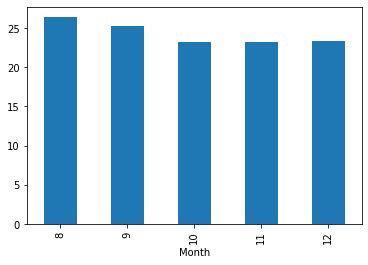

In [27]:
type_pumpkin.groupby('Month')['Price'].mean().plot(kind='bar')

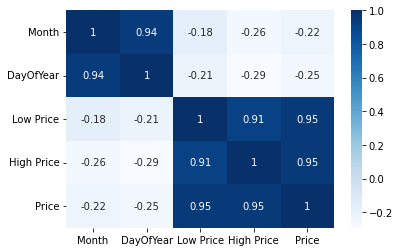

In [33]:
correl=type_pumpkin.corr(method='pearson')
sns.heatmap(correl,cmap='Blues',annot=True);

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,FunctionTransformer,PolynomialFeatures
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [8]:
X = type_pumpkin.drop(['Price','Low Price','High Price'],axis=1)

y = type_pumpkin['Price']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [9]:
numeric_features=['Month','DayOfYear']
categorical_features=list(type_pumpkin.drop(numeric_features,axis=1).drop(['Price','Low Price','High Price'],axis=1))

In [10]:
categorical_features

['Variety', 'City', 'Package']

In [136]:
def encoder(x):
    enc=OneHotEncoder(handle_unknown='ignore',drop='first')
    enc_data=pd.DataFrame(enc.fit_transform(x).toarray)
    enc_data.columns=enc.get_feature_names_out()
    return enc_data

encoders=FunctionTransformer(encoder)


In [11]:
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean'))
      ])

categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant'))
      ,('encoder', OneHotEncoder())
      ])

In [12]:
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
   ,('categorical', categorical_transformer, categorical_features)
   ]) 

In [33]:
model=Pipeline(steps=[
    ('polynomial',PolynomialFeatures(2)),
    ('regression',LinearRegression())
])

In [42]:
pipe= make_pipeline(preprocessor,model)
pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Month', 'DayOfYear']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Variety', 'City',
                                                   'Package'])])),
                ('pipeline',
                 Pipeline(steps=[('polynomial', PolynomialFeatures()),
                                 ('regression', LinearRegression())]))])

In [43]:
y_pred_test = pipe.predict(X_test)

#### Sklearn Metrics

In [45]:
mse=np.sqrt(mean_squared_error(y_test,y_pred_test))
mse

2.5922818317151815

In [44]:
score=pipe.score(X_train,y_train)
score

0.6878184907732265

#### Others enquiry

In [160]:
#Used to utilize pipeline to turn dataframe into preprocessing standard value.

asx=pd.DataFrame(pipe.fit_transform(type_pumpkin))
asx.columns=pipe.get_feature_names_out()
asx

,numeric__Month,numeric__DayOfYear,categorical__Variety_PIE TYPE,categorical__City_ATLANTA,categorical__City_BALTIMORE,categorical__City_BOSTON,categorical__City_CHICAGO,categorical__City_COLUMBIA,categorical__City_DETROIT,categorical__City_NEW YORK,categorical__City_PHILADELPHIA,categorical__City_SAN FRANCISCO,categorical__Package_1 1/9 bushel cartons,categorical__Package_1 1/9 bushel crates,categorical__Package_bushel cartons
0,9.0,267.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,9.0,267.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,10.0,274.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,10.0,274.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,10.0,281.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,10.0,295.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
140,10.0,302.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
141,8.0,237.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
142,9.0,258.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
